# random walk

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics

import statsmodels.tsa.stattools as sts # adf test
import statsmodels.graphics.tsaplots as sgt # plot acf

before starting with a dataset, let's simulate a random walk, this will help us understand what it is

In [2]:
np.random.seed(42)

# generate a thousand random numbers 
steps = np.random.standard_normal(1000)

# first value of the series as 0
steps[0] = 0

# calculate the cumulative sum of errors 
# for each timestep in the simulated process
random_walk = np.cumsum(steps)

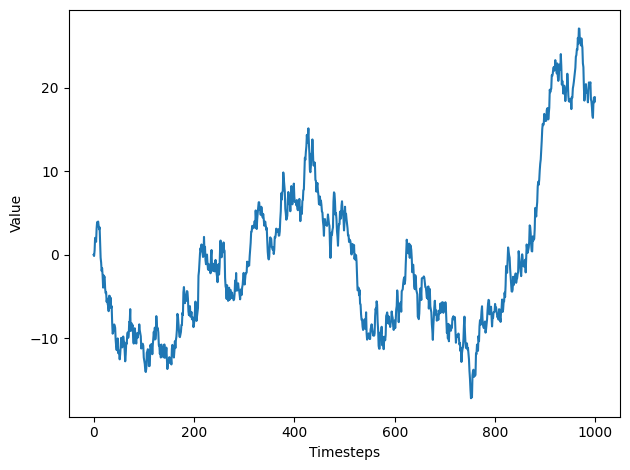

In [3]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [4]:
adf_result = sts.adfuller(random_walk)

In [5]:
print(f'adf statistic {adf_result[0]}')
print(f'p-value {adf_result[1]}')

adf statistic -0.9659524876918759
p-value 0.7654789696692579


the ad statisitc is not a large negative number and p calue is greater than 0.05, therefore our time series is not stationary

The statsmodels library conveniently has a function to quickly plot the ACF.

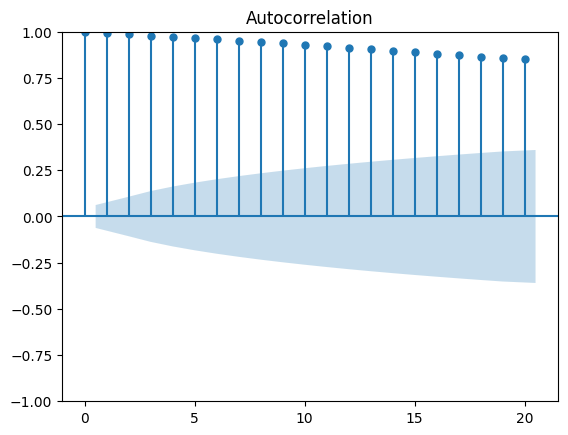

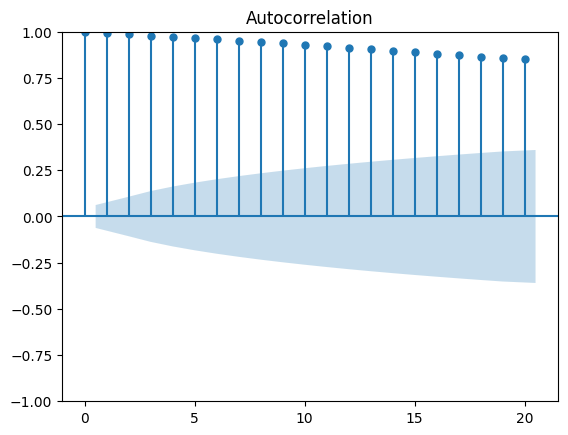

In [6]:
sgt.plot_acf(random_walk, lags = 20)

Because our random walk is not stationary, we need to apply a transformation to make it stationary in order to retrieve useful information from the ACF plot

### making our random walk stationary

we will use differencing, applying this transformation will make it stationary. Let's keep in mind that we will loose one data point when we do this, since the first element can not be differenced with anything

In [7]:
# with n = 1 we set the order of the differencing
diff_random_walk = np.diff(random_walk, n=1)

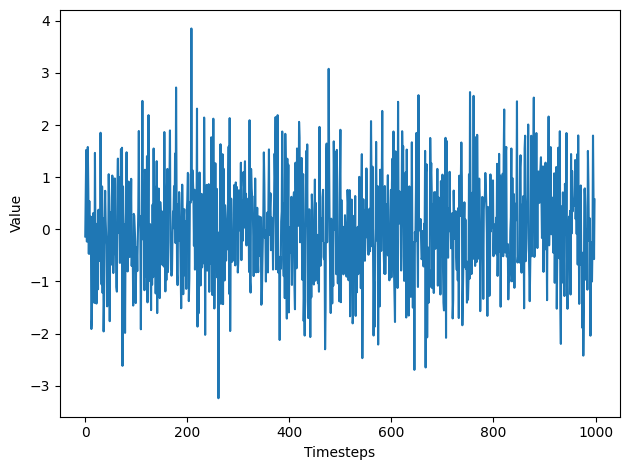

In [8]:
fig, ax = plt.subplots()

ax.plot(diff_random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

we have removed the trend from our dataset, will test for stationary again:

In [9]:
adf_result = sts.adfuller(diff_random_walk)
print(f'adf statistic {adf_result[0]}')
print(f'p-value {adf_result[1]}')

adf statistic -31.7893108575606
p-value 0.0


From the book:
> This time the ADF statistic is a large negative number, and the p-value is less than 0.05. Therefore, we reject the null hypothesis, and we can say that this process has no unit root and is thus stationary.

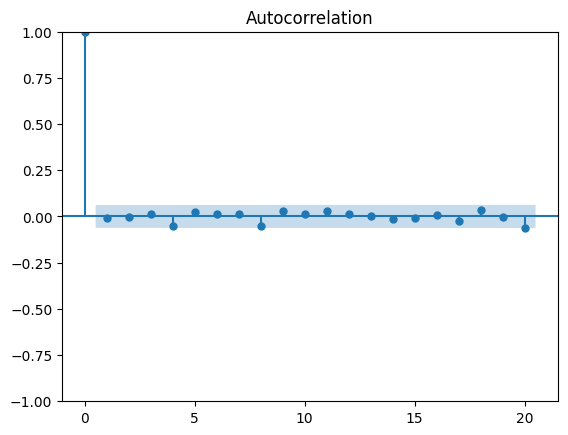

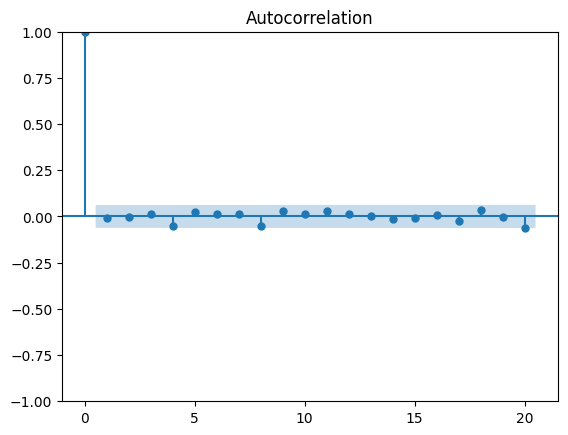

In [10]:
sgt.plot_acf(diff_random_walk, lags = 20)

there is no significant autocorrelation coeficients after lag 0. This means that the process is completely random. Each value is a random step away from the previous one

## let's try with GOOGL stock (27/04/2020 - 27/04/2021)

In [11]:
df = pd.read_csv('googl.csv')

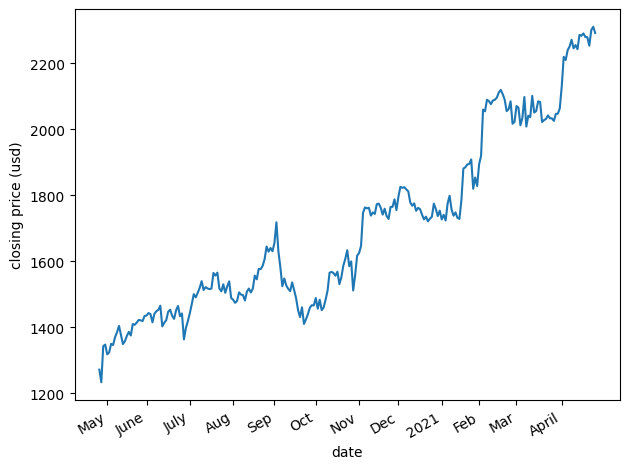

In [12]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('date')
ax.set_ylabel('closing price (usd)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 
        'Dec', 2021, 'Feb', 'Mar', 'April']
)
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
googl_adf = sts.adfuller(df['Close'])
print(f'adf statistic {googl_adf[0]}')
print(f'p-value {googl_adf[1]}')

adf statistic 0.16025048664771477
p-value 0.9699419435913058


not large enought negative number, and p-value bigger than 0.05 so definitely not stationary

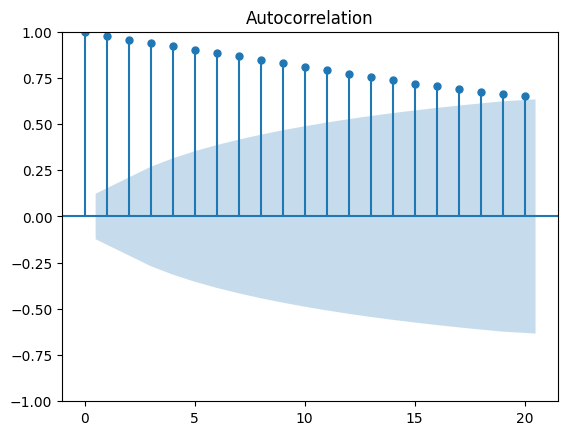

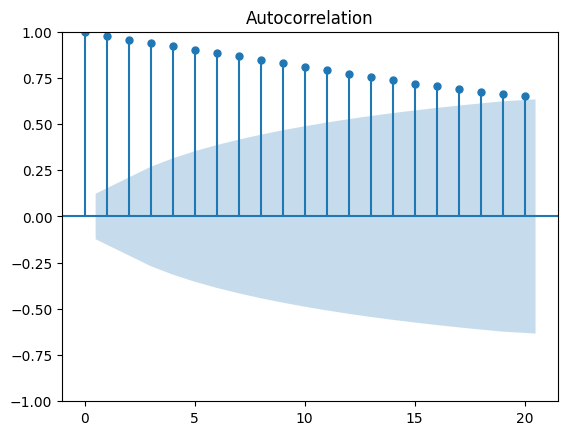

In [14]:
sgt.plot_acf(df['Close'], lags = 20)

let's make the transformation to make it stationary

In [15]:
diff_googl = np.diff(df['Close'], n = 1)

In [16]:
diff_googl_adf = sts.adfuller(diff_googl)
print(f'adf statistic {diff_googl_adf[0]}')
print(f'p-value {diff_googl_adf[1]}')

adf statistic -5.303439704295217
p-value 5.386530961454999e-06


so the p-value is less than -0.05, so now it is stationary, let's plot acf to see how it looks.

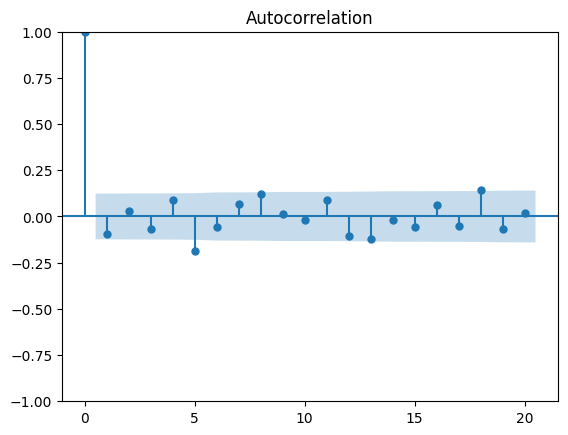

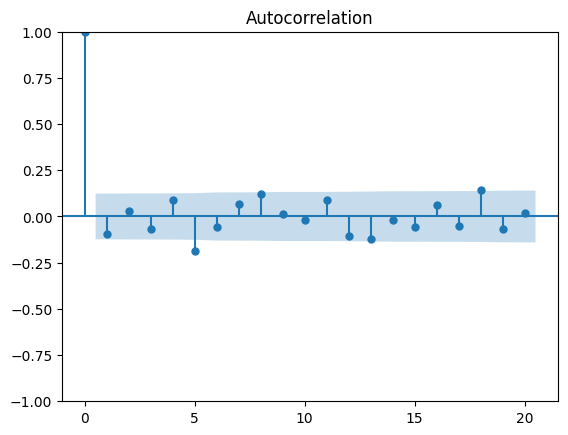

In [17]:
sgt.plot_acf(diff_googl, lags = 20)

## forecasting a random walk long term (spoiler you can't)

we've established that we have a random walk, so the only forecasting methods we have are pretty poor. We can take the naive ones we used in the baseline, like taking the historical mean, or the last known value. The book does this but I wont do it because it is not worth the trouble.

nevertheless, there is one method that the book mentions here that we have not covered it, so I'll implement this last one:

In [18]:
# load our random walk into a df and split in train and test
df = pd.DataFrame({'value': random_walk})

train = df[:800]
test = df[800:]

### the drift method

basically getting the slope and extrapolating the straight line into the future

In [19]:
# get the slope
delta_x = 800 - 1

last_value = train.iloc[-1].value
delta_y = last_value - 0

In [20]:
drift = delta_y / delta_x

In [21]:
drift

-0.008529346056640632

this value means that the slope of our data set will decrease slowly. We want to predict the next 200 timesteps.

In [22]:
# create the list of time steps
x_vals = np.arange(800, 1000, 1)

pred_drift = drift * x_vals

In [23]:
test.loc[:, 'pred_drift'] = pred_drift

/var/folders/5r/60f9npy54bz3_gzp5pkztxzw0000gn/T/ipykernel_7475/3808768418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_drift'] = pred_drift


In [24]:
test.head()

,value,pred_drift
800,-5.876664,-6.823477
801,-6.392708,-6.832006
802,-6.296588,-6.840536
803,-6.758863,-6.849065
804,-7.193359,-6.857594


lets plot our result

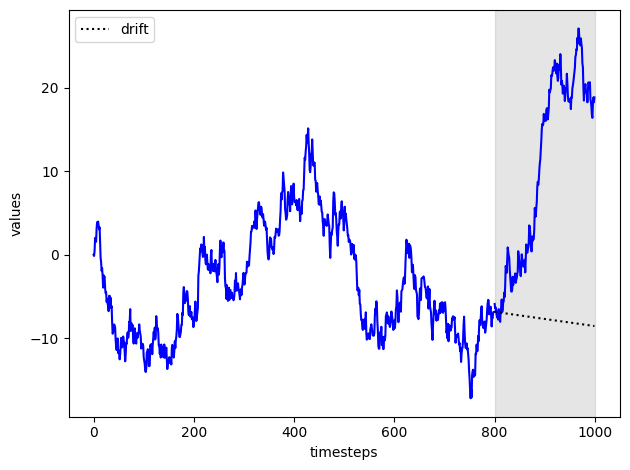

In [25]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test.value, 'b-')
ax.plot(test.pred_drift, 'k:', label = 'drift')

ax.axvspan(800, 1000, color = '#808080', alpha = 0.2)

ax.legend(loc = 2)

ax.set_xlabel('timesteps')
ax.set_ylabel('values')

plt.tight_layout()

well, that was disappointing :(. Nevertheless let's check the MSE, we dont use MAPE, because in a random walk the value can be 0, and this implies dividing by 0

In [27]:
sklearn.metrics.mean_squared_error(test['value'], test['pred_drift'])

465.9076036601397

it is really big

## forecasting next step on random walk

since the value of a random walk is the past value by some random number, if we
take the last value we will be off just by that random number

this might look deceving to untrained eyes, because even the MSE is low. But
remeber we are just taking the last known value at each timestep and inserting
it in the next.

In [29]:
df_shift = df.shift(periods = 1)

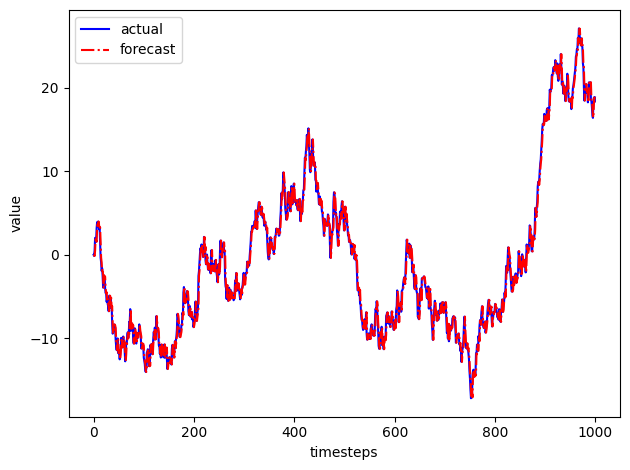

In [30]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('timesteps')
ax.set_ylabel('value')
plt.tight_layout()